## 1 - Load Dataset

In [1]:
from rep_graph_sample.dataset import ogb_dataset_to_nx_graph

dataset_name = 'ogbn-arxiv'

graph = ogb_dataset_to_nx_graph(dataset_name)

print(f'# of Nodes: {graph.number_of_nodes():_}\n# of Edges: {graph.number_of_edges():_}')

# of Nodes: 169_343
# of Edges: 1_157_799


## 2 - Sample Random Subgraph

In [2]:
import random
from tqdm import tqdm
import numpy as np
from rep_graph_sample.graph import SubgraphHandler

subgraph_size = 100

# Get an initial subgraph node set
subgraph_nodes = list(np.random.choice(graph.nodes(), size=(subgraph_size), replace=False))
#subgraph_nodes = list(np.load('0.151-60k.npy'))

subgraph = SubgraphHandler(
    full_graph = graph, 
    initial_node_set = subgraph_nodes
)

print(f'Initial KS Distance: {subgraph.ks_distance():.5}')

Initial KS Distance: 1.0


## 3 - Metropolis-Hastings

In [3]:
num_iters = 10_000

exponent = 400

In [4]:
from rep_graph_sample.logger import RunHistory

logger = RunHistory(subgraph_handler=subgraph,
                    save_interval=100,
                    p=exponent)

print(f'Saving every {logger.save_interval:_} iterations for a total of {num_iters // logger.save_interval} saves over {num_iters:_} iterations.')

Saving every 100 iterations for a total of 100 saves over 10_000 iterations.


In [5]:
prev_ks_dist = subgraph.ks_distance()

for i in (pbar := tqdm(range(num_iters))):
    # Randomly pick nodes to remove and add to the subgraph
    num_nodes_to_change = np.random.randint(1, 6)
    remove_nodes = np.random.choice(subgraph.nodes, size=(num_nodes_to_change,), replace=False)
    add_nodes = np.random.choice(subgraph.nodes_not_in_subgraph, size=(num_nodes_to_change,), replace=False)

    for node in remove_nodes:
        subgraph.remove(node)
    for node in add_nodes:
        subgraph.add(node)

    # Calculate the new Degree KS Distance
    new_ks_dist = subgraph.ks_distance()

    ratio = prev_ks_dist / new_ks_dist
    if ratio >= 1.0:
        # Accept
        prev_ks_dist = new_ks_dist
        accepted = True
    else:
        score = ratio ** exponent
        prop = random.random()
        if score > prop:
            # Accept
            prev_ks_dist = new_ks_dist
            accepted = True
        else:
            # Reject and revert back
            for node in add_nodes:
                subgraph.remove(node)
            for node in remove_nodes:
                subgraph.add(node)
            accepted = False

    pbar.set_description(f'KS Dist: {prev_ks_dist:.5}')
    logger.log(ratio=ratio, accepted=accepted)

KS Dist: 0.53895: 100%|██████████| 10000/10000 [14:05<00:00, 11.83it/s]


Acceptance Ratio: 42.09%


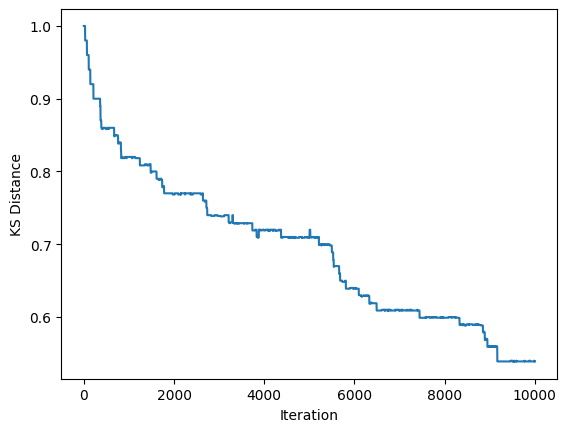

In [6]:
import matplotlib.pyplot as plt

logger.plot_distances()

print(f'Acceptance Ratio: {logger.acceptance_ratio:.2%}')

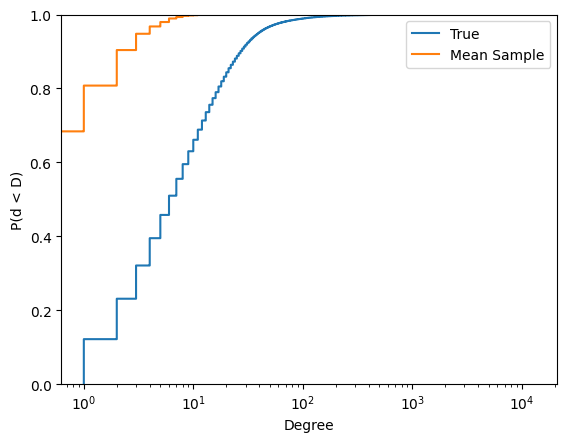

In [7]:
logger.plot_degree_distributions()

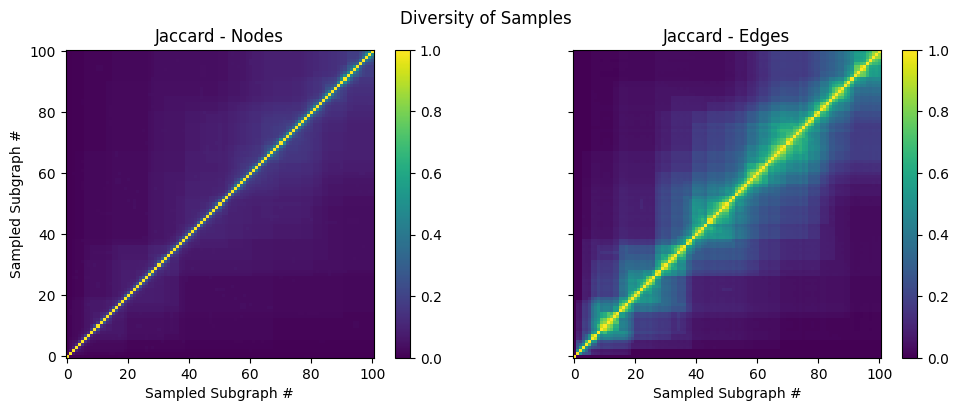

In [8]:
logger.plot_sample_similarity()

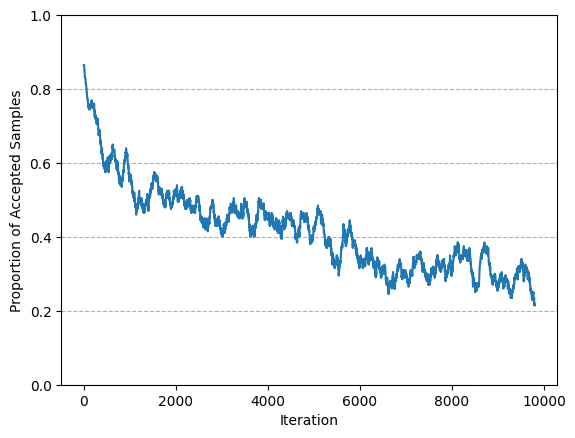

In [9]:
logger.plot_acceptance_ratio()

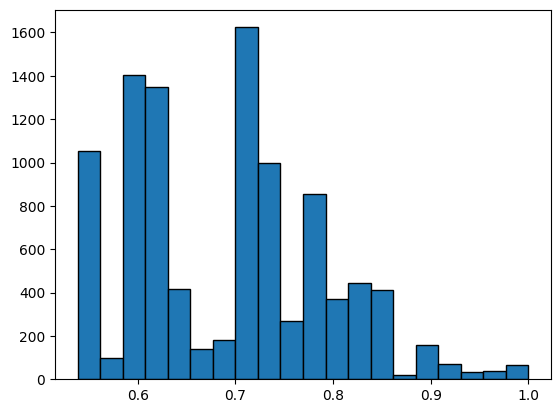

In [10]:
_ = plt.hist(logger.distances, bins=20, edgecolor='k')

In [11]:
# logger.save_run()
# logger.export_samples()